## ATAC + MULTIOME SUPPORTING CELLS (april 2021)

### Dimensionality reduction with cisTopic for single samples from cellatac

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


**r2py setup**

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)

**Load data**

In [7]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/supporting_apr2021/"
experiment_prefix = 'supporting_'

In [8]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

In [9]:
adata.X

<34015x170503 sparse matrix of type '<class 'numpy.float32'>'
	with 174399944 stored elements in Compressed Sparse Row format>

**Setup of cisTopic**

In [10]:
# Remove empty rows
bool_matrix = adata.X.sum(0) > 0
bool_vector = np.squeeze(np.asarray(bool_matrix))
adata = adata[:, bool_vector]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
adata

View of AnnData object with n_obs × n_vars = 34015 × 170503
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

**Assess if there are cells with very low number of counts**

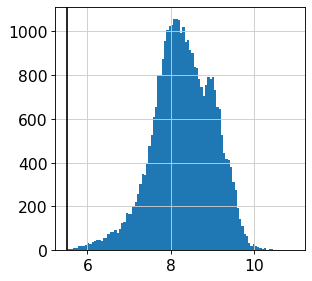

In [12]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=5.5, color="black")

**Convert anndata to SingleCellExperiment**

In [13]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 170503 34015 
metadata(0):
assays(2): X binary_raw
rownames(170503): chr1:816745-817421 chr1:825662-826063 ...
  chrY:20574989-20576365 chrY:22727855-22729057
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(34015): 01-AAACGAAAGGCTCCTG-1 01-AAACGAAAGTCCAGAG-1 ...
  10-TTTGTGTGTGCTGAAG-1 10-TTTGTGTGTTAACCGT-1
colData names(9): cellatac_clusters n_genes_by_counts ...
  pct_counts_in_top_200_genes pct_counts_in_top_500_genes
reducedDimNames(0):
altExpNames(0):


**Train cisTopic model**

In [14]:
%%R 

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

cisTopicObject

An object of class cisTopic in project ATAC_cisTopic 
 170503 regions across 34015 samples.


In [15]:
%%R -i outdir -i experiment_prefix
#options(future.globals.maxSize = 1000 * 1024^2)

topics_vec <- c(20, 21, 22, 23, 24,25, 26, 27, 28, 29, 30)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic = topics_vec, 
                                   seed = 1712, 
                                   nCores = 11, 
                                   iterations = 500
                                  )

## Save trained models
saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

[1] "Exporting data..."
[1] "Run models..."


In [9]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "_ATAC.trainedCistopic.RDS"))

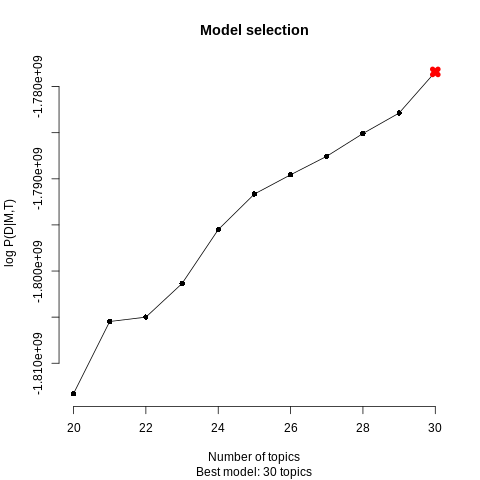

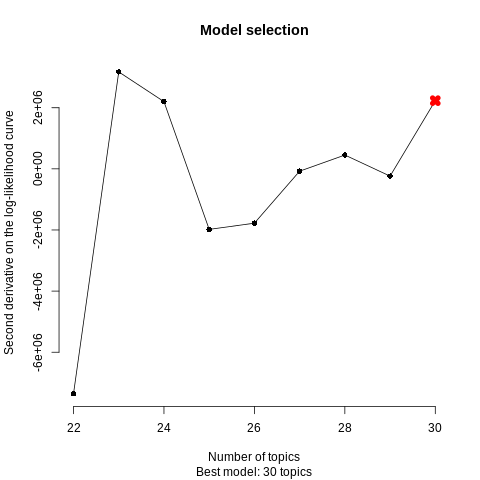

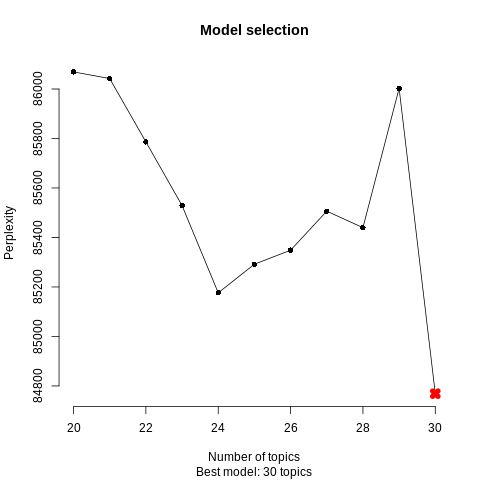

In [10]:
%%R

cistopic_model <- selectModel(cisTopicObject, type = "maximum")

In [18]:
%%R -o topicXcell
## Save topic matrix ##
topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')

dim(topicXcell)

[1]    30 34015


In [19]:
topicXcell

array([[0.06067935, 0.04987584, 0.07305847, ..., 0.01394681, 0.02990925,
        0.02690104],
       [0.23903533, 0.05420248, 0.01379065, ..., 0.00610293, 0.04996219,
        0.02854267],
       [0.11415761, 0.08760267, 0.11389728, ..., 0.10642816, 0.09159314,
        0.07168964],
       ...,
       [0.01199728, 0.01719198, 0.01132042, ..., 0.09181175, 0.03114444,
        0.01969955],
       [0.02070652, 0.05616046, 0.00422961, ..., 0.00740386, 0.01923368,
        0.01887874],
       [0.05230978, 0.16617956, 0.00319886, ..., 0.00045915, 0.01313335,
        0.0205978 ]])

In [20]:
adata.obsm['X_cistopic_30'] = topicXcell.T

**Visualize dimensionality reduction results**

In [21]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_cistopic_30")

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


In [22]:
sc.tl.umap(adata, min_dist = 0.4, spread = 1)

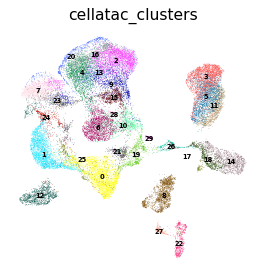

In [23]:
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color = "cellatac_clusters", frameon = False, size = 1, legend_loc = 'on data', legend_fontsize = 6)


In [24]:
adata

AnnData object with n_obs × n_vars = 34015 × 170503
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors'
    obsm: 'X_cistopic_30', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

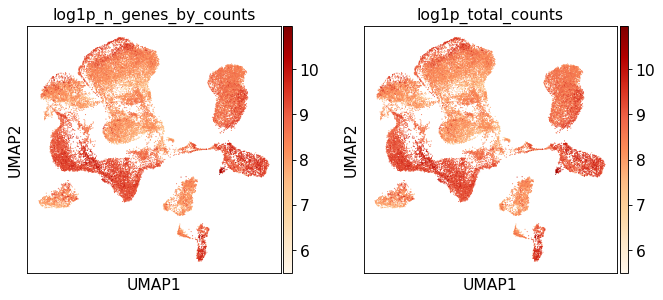

In [25]:
sc.pl.umap(adata, color = ['log1p_n_genes_by_counts', 'log1p_total_counts'], ncols = 2, color_map = "OrRd")

**Add metadata for females**

In [26]:
adata.shape

(34015, 170503)

In [27]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

01    6618
06    3533
07    3147
05    2963
17    2448
13    2406
08    2041
15    1828
18    1745
16    1357
03    1033
09    1022
20     946
19     907
12     726
10     449
11     364
02     219
22     111
04      86
21      66
Name: code, dtype: int64

In [28]:
# Sample from code 
sample_dictionary = {'01' : 'FCA_GND8046539', '02' : 'FCA_GND8768483', '03' : 'FCA_GND8768484', 
                    '04' : 'FCA_GND8768487', '05' : 'HD_F_GON9479871', '06' : 'HD_F_GON9479873', 
                     '07' : 'HD_F_GON9479874', '08' : 'HD_F_GON9479875', '09' : 'HD_F_GON9883959', 
                    '10' : 'HD_F_GON9883960', '11' : 'FCA_GND8768481', '12' : 'FCA_GND8768482', 
                    '13' : 'FCA_GND8768485',  '15' : 'FCA_GND8795927', 
                    '16' : 'FCA_GND8795928', '17' : 'HD_F_GON9479872', '18' : 'FCA_GND9332157', 
                    '19' : 'HD_F_GON9525611', '20' : 'HD_F_GON9525612', '21' : 'HD_F_GON9525613',
                    '22' : 'HD_F_GON9525614'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

FCA_GND8046539     6618
HD_F_GON9479873    3533
HD_F_GON9479874    3147
HD_F_GON9479871    2963
HD_F_GON9479872    2448
FCA_GND8768485     2406
HD_F_GON9479875    2041
FCA_GND8795927     1828
FCA_GND9332157     1745
FCA_GND8795928     1357
FCA_GND8768484     1033
HD_F_GON9883959    1022
HD_F_GON9525612     946
HD_F_GON9525611     907
FCA_GND8768482      726
HD_F_GON9883960     449
FCA_GND8768481      364
FCA_GND8768483      219
HD_F_GON9525614     111
FCA_GND8768487       86
HD_F_GON9525613      66
Name: sample, dtype: int64

In [29]:
sex_dictionary = {
    'FCA_GND8046539' : 'female', 'FCA_GND8768484' : 'female', 'FCA_GND8768483' : 'female', 
                    'HD_F_GON9479874' : 'female', 'HD_F_GON9479871' : 'female', 'HD_F_GON9479873' : 'female',
                  'HD_F_GON9479875' : 'female', 
                    'FCA_GND8768485' : 'female', 'HD_F_GON9525613' : 'female', 'HD_F_GON9525614' : 'female',
                 'HD_F_GON9883959' : 'female', 'HD_F_GON9883960' : 'female',
    'FCA_GND8795927' : 'male',  
                 'FCA_GND8795928' : 'male', 'FCA_GND8768482' : 'male',  
                 'FCA_GND8768481' : 'male', 'FCA_GND8768487' : 'male', 
                 'HD_F_GON9479872' : 'male', 'HD_F_GON9525611' : 'male', 'HD_F_GON9525612' : 'male', 
                 'FCA_GND9332157' : 'male'
}
adata.obs['sex'] = adata.obs['sample'].map(sex_dictionary)
adata.obs['sex'].value_counts(dropna = False)

female    23608
male      10407
Name: sex, dtype: int64

In [30]:
stage_dictionary = {
    'FCA_GND8046539' : '8 PCW', 'FCA_GND8768484' : '8 PCW', 'FCA_GND8768483' : '14 PCW', 
                    'HD_F_GON9479874' : '14 PCW', 'HD_F_GON9479871' : '14 PCW', 'HD_F_GON9479873' : '13 PCW',
                  'HD_F_GON9479875' : '14 PCW', 
                    'FCA_GND8768485' : '9 PCW', 'HD_F_GON9525613' : '14 PCW', 'HD_F_GON9525614' : '14 PCW', 
                   'HD_F_GON9883959' : '18 PCW', 'HD_F_GON9883960' : '21 PCW',
    'FCA_GND8795927' : '7 PCW', 
                   'FCA_GND8795928' : '12 PCW', 'FCA_GND8768482' : '11 PCW',  
                   'FCA_GND8768481' : '19 PCW', 'FCA_GND8768487' : '12 PCW', 
                 'HD_F_GON9479872' : '15 PCW', 'HD_F_GON9525611' : '12 PCW', 'HD_F_GON9525612' : '12 PCW', 
                   'FCA_GND9332157' : '17 PCW'
}
adata.obs['stage'] = adata.obs['sample'].map(stage_dictionary)
adata.obs['stage'].value_counts(dropna = False)

14 PCW    8547
8 PCW     7651
13 PCW    3533
12 PCW    3296
15 PCW    2448
9 PCW     2406
7 PCW     1828
17 PCW    1745
18 PCW    1022
11 PCW     726
21 PCW     449
19 PCW     364
Name: stage, dtype: int64

In [31]:
individual_dictionary = {
    'FCA_GND8795927' : 'Hrv17',  
                   'FCA_GND8795928' : 'Hrv18', 'FCA_GND8768482' : 'Hrv10',  
                   'FCA_GND8768481' : 'Hrv3', 'FCA_GND8768487' : 'Hrv15', 
                 'HD_F_GON9479872' : 'Hrv40', 'HD_F_GON9525611' : 'Hrv15', 'HD_F_GON9525612' : 'Hrv15', 
                        'FCA_GND9332157' : 'Hrv21',
    'FCA_GND8046539' : 'F81', 'FCA_GND8768484' : 'Hrv12', 'FCA_GND8768483' : 'Hrv11', 
                    'HD_F_GON9479874' : 'Hrv50', 'HD_F_GON9479871' : 'Hrv39', 'HD_F_GON9479873' : 'Hrv49',
                  'HD_F_GON9479875' : 'Hrv50', 
                    'FCA_GND8768485' : 'Hrv13', 'HD_F_GON9525613' : 'Hrv39', 'HD_F_GON9525614' : 'Hrv39',
                        'HD_F_GON9883959' : 'Hrv59', 'HD_F_GON9883960' : 'Hrv58'
}
adata.obs['individual'] = adata.obs['sample'].map(individual_dictionary)
adata.obs['individual'].value_counts(dropna = False)

F81      6618
Hrv50    5188
Hrv49    3533
Hrv39    3140
Hrv40    2448
Hrv13    2406
Hrv15    1939
Hrv17    1828
Hrv21    1745
Hrv18    1357
Hrv12    1033
Hrv59    1022
Hrv10     726
Hrv58     449
Hrv3      364
Hrv11     219
Name: individual, dtype: int64

**Plot metadata information**

... storing 'code' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'stage' as categorical
... storing 'individual' as categorical


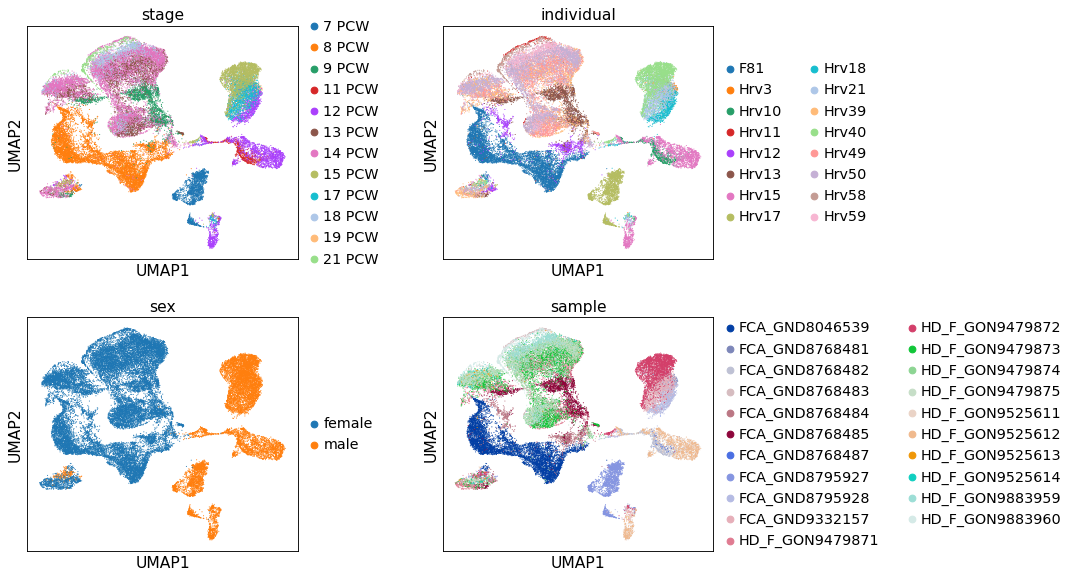

In [32]:
sc.pl.umap(adata, color = ['stage', 'individual', 'sex', 'sample'], ncols = 2, wspace = 0.4)

Explore the region x topic probability matrix 

In [33]:
#%%R 

#install.packages("bigmemory")

In [11]:
%%R -o p_mat

library(bigmemory)
p_mat <- predictiveDistribution(cistopic_model, big.matrix=FALSE)

In [12]:
%%R
dim(p_mat)

[1] 170503  34015


In [36]:
p_mat

array([[1.19557406e-06, 1.67985863e-06, 4.22483855e-07, ...,
        1.88446848e-06, 2.41534310e-06, 2.52780782e-06],
       [2.23022218e-06, 2.58492840e-06, 2.75026770e-06, ...,
        5.65142496e-06, 6.53121393e-06, 5.97851189e-06],
       [2.92540082e-05, 2.74141517e-05, 3.92228041e-05, ...,
        4.83062982e-05, 3.26355446e-05, 3.16056970e-05],
       ...,
       [1.55203412e-07, 4.17368345e-07, 2.52302128e-07, ...,
        1.70144064e-07, 2.11788443e-07, 2.08312752e-07],
       [5.28785930e-06, 1.32192711e-05, 2.02237996e-06, ...,
        2.26510614e-06, 4.93776176e-06, 4.79669965e-06],
       [8.31524717e-07, 2.81215913e-06, 1.22679227e-06, ...,
        4.88287280e-07, 1.18287793e-06, 1.22540913e-06]])

### Save p_mat for downstream analysis of Cicero --> can't, too big and can't be converted to sparse nor saved in compressed format!

In [13]:
p_mat_transpose = p_mat.T 

#### Important: 

cistopic_p is a numpy array (cannot convert to sparse matrix because it crashes), and it is too large to save --> will save it in a separate object

In [38]:
adata.layers["cistopic_p"] = p_mat.T

**Calculate de-noised gene scores**

In [39]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
# library(Signac)

In [40]:
%%R

StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [41]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [42]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

In [43]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

In [44]:
gene_mat = adj_mat.dot(p_mat) 

In [45]:
gene_mat

array([[3.26798045e-05, 3.16789388e-05, 4.23955556e-05, ...,
        5.58421917e-05, 4.15821016e-05, 4.01120167e-05],
       [2.85230639e-05, 2.93908681e-05, 3.58701125e-05, ...,
        4.30604936e-05, 3.44717073e-05, 3.12815717e-05],
       [2.85230639e-05, 2.93908681e-05, 3.58701125e-05, ...,
        4.30604936e-05, 3.44717073e-05, 3.12815717e-05],
       ...,
       [4.36732750e-06, 1.17919724e-05, 5.34516170e-06, ...,
        2.78123777e-06, 5.39158929e-06, 5.41797854e-06],
       [8.48221308e-06, 2.22576528e-05, 6.25989814e-06, ...,
        4.29348357e-06, 8.98094727e-06, 8.88999740e-06],
       [6.24839948e-06, 1.58552754e-05, 3.94508028e-06, ...,
        3.01131776e-06, 6.33586118e-06, 6.24155049e-06]])

Save another anndata object with the same .obs as the original one, but storing the gene score info.

In [46]:
%%R -i gene_mat -o predMatSumByGene

# Multiply and round predictive matrix to be able to integrate with scRNAseq data
predMatSumByGene <- round(gene_mat * 1000000)

In [47]:
gene_var = gene_var.set_index("gene_name")
gene_var.head()

,gene_id
gene_name,
RP5-857K21.4,ENSG00000230021
FAM41C,ENSG00000230368
TUBB8P11,ENSG00000234711
FAM166AP3,ENSG00000283040
RP11-54O7.16,ENSG00000272438


In [48]:
predMatSumByGene = predMatSumByGene.T
predMatSumByGene.shape

(34015, 17356)

In [49]:
gene_adata = anndata.AnnData(X=predMatSumByGene, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 34015 × 17356
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'

In [50]:
gene_adata.var_names_make_unique()

In [51]:
# Add cisTopic dimensionality reduction to match visualization 
gene_adata.obsm['X_cistopic_30'] = topicXcell.T

In [52]:
adata

AnnData object with n_obs × n_vars = 34015 × 170503
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'stage_colors', 'individual_colors', 'sex_colors', 'sample_colors'
    obsm: 'X_cistopic_30', 'X_umap'
    layers: 'binary_raw', 'cistopic_p'
    obsp: 'distances', 'connectivities'

In [53]:
del adata.layers['cistopic_p']

In [54]:
adata

AnnData object with n_obs × n_vars = 34015 × 170503
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'umap', 'cellatac_clusters_colors', 'stage_colors', 'individual_colors', 'sex_colors', 'sample_colors'
    obsm: 'X_cistopic_30', 'X_umap'
    layers: 'binary_raw'
    obsp: 'distances', 'connectivities'

**Save anndata objects**

In [55]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [56]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

**Proceed with gene_data to look at marker genes**

In [57]:
sc.pp.neighbors(gene_adata, n_neighbors=15, use_rep="X_cistopic_30")

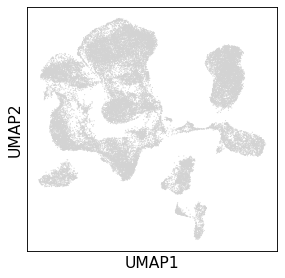

In [58]:
sc.tl.umap(gene_adata, min_dist = 0.4, spread = 1)
sc.pl.umap(gene_adata)

**Plot markers per cell type from RNA-seq**

In [59]:
mesothelial = ['LRRN4', 'UPK3B', 'KLK11'] 
gonad_somatic_cells = ['NR5A1', 'AMHR2', 'MIR202HG'] 
supporting = ['WNT6', 'WIPF3']
supporting_LGR5 = ['LGR5']
supporting_PAX8 = ['PAX8']
preGranulosa_lineage = ["KITLG",  'RSPO1', 'OSR1' , 'NR4A1']
granulosa_lineage = ['FOXL2', 'IRX3', 'CYP19A1', 'RDH10']
sertoli_lineage = ['SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA', 'TFF3', 'DKK3']
mesenchymal_steroidogenic = ['CYP11A1', 'CYP17A1', 'STAR',  'MGARP', 'FDXR']
leydigFetal_lineage = ['FDX1'] # Not there
leydig_lineage = ['INSL3', 'GLI1', 'HHIP', 'PTCH2']
preTheca_lineage = ['KIT', 'LHCGR'] # Not there
mesenchymal = ['DCN', 'PDGFRA','TCF21', 'OGN', 'POSTN']
gonadal_mesenchymal = ['LHX9', 'GATA4']
ovary_stroma = ['SPRR2F', 'AKR1C1', 'DIRAS3'] # Not there
testis_border_mesenhyme = ['IGF1', 'FGL2', 'PCSK2', 'ANGPTL1']
testis_myoid= ['PTCH1', 'NGFR', 'MSC', 'NEFL']
extragonadal_mesen = ['GATA2', 'NR2F1', 'WNT4', 'RSPO3', 'MEIS1', 'FAP']
mesoneprhic_stroma = ['CRABP1', 'ALX1',  'FOXD1']
gonad_dev = ['EMX2', 'WT1']
muscoskeletal = ['MYF5','PAX7','MYF6', 'MYLPF']
epithelial = ["EPCAM"]
PGCs= ['POU5F1', 'NANOG', 'NANOS3']
GCs = ['DAZL', 'DDX4']
immunePGCs= ['PTPRC']
endothelial = ['PECAM1', 'VWF', 'CDH5']
erythroid = ["GYPC", "HBA1"]
neural = ['ASCL1', 'ELAVL4']
PV = ["PDGFRB", 'ACTA2']
cycling = ['CDK1', 'MKI67'] # Not there
quiescent = ['CDKN1B']
male = ['SRY', 'RPS4Y1','DDX3Y'] # Not there

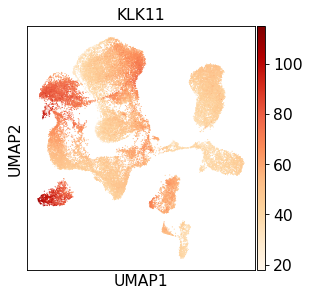

In [60]:
# Mesothelial
sc.pl.umap(gene_adata, color = ['KLK11'], ncols = 3, color_map = 'OrRd')

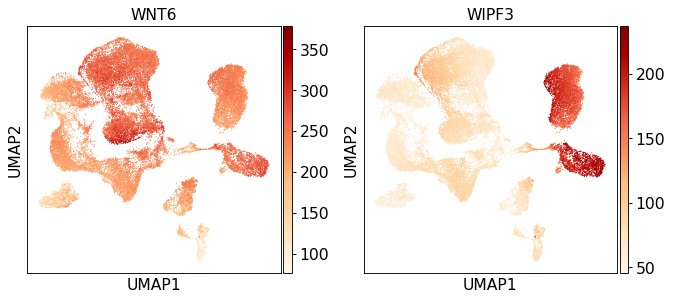

In [61]:
sc.pl.umap(gene_adata, color = supporting, ncols = 3, color_map = 'OrRd')

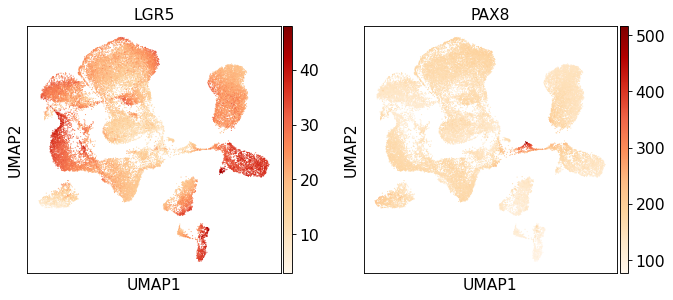

In [62]:
sc.pl.umap(gene_adata, color = ['LGR5', 'PAX8'], ncols = 3, color_map = 'OrRd')

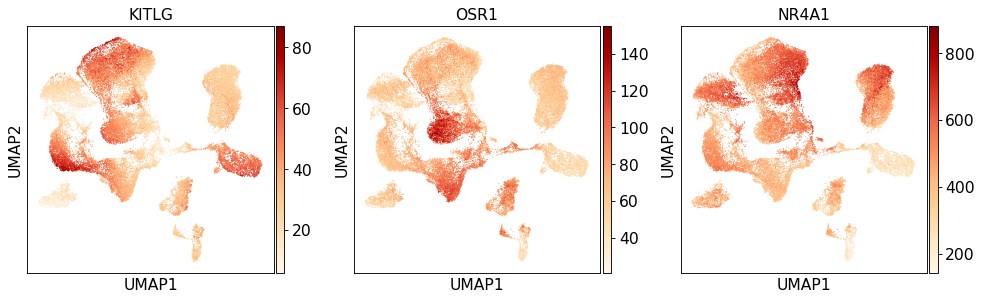

In [63]:
# Pregranulosa
sc.pl.umap(gene_adata, color = ["KITLG", 'OSR1' , 'NR4A1'], ncols = 3, color_map = 'OrRd')

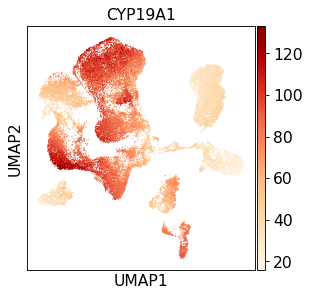

In [64]:
# Granulosa 
sc.pl.umap(gene_adata, color = ['CYP19A1'], ncols = 2, color_map = 'OrRd')

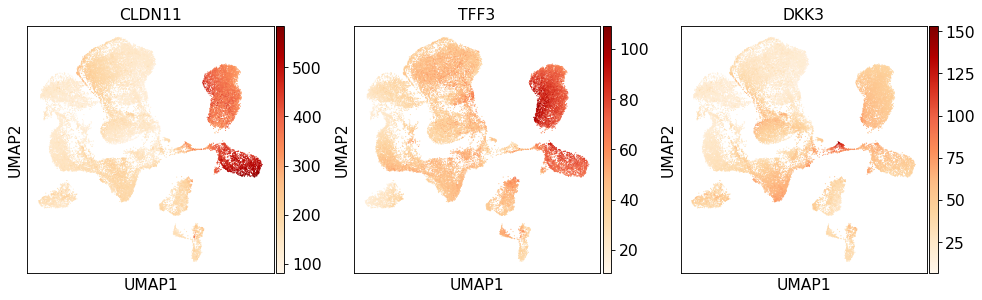

In [65]:
# Sertoli lineage
sc.pl.umap(gene_adata, color = [ 'CLDN11', 'TFF3', 'DKK3'], ncols = 3, color_map = 'OrRd')

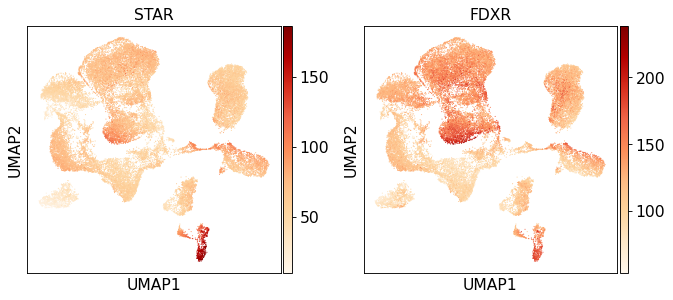

In [66]:
# Steroidogenic mesenchymal 
sc.pl.umap(gene_adata, color = ['STAR',  'FDXR'], ncols = 3, color_map = 'OrRd')

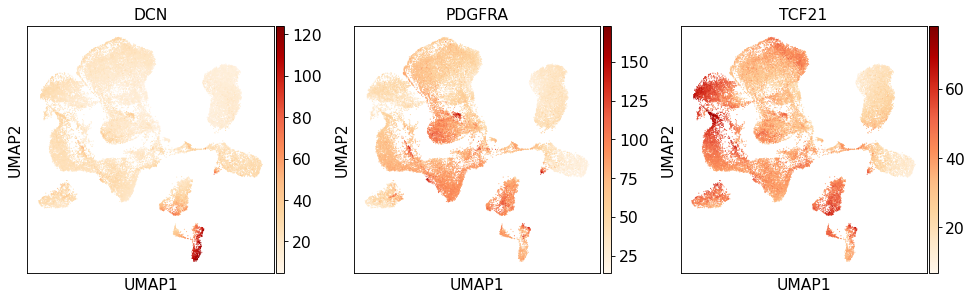

In [67]:
# Mesenchymal 
sc.pl.umap(gene_adata, color = ['DCN', 'PDGFRA','TCF21'], ncols = 3, color_map = 'OrRd')

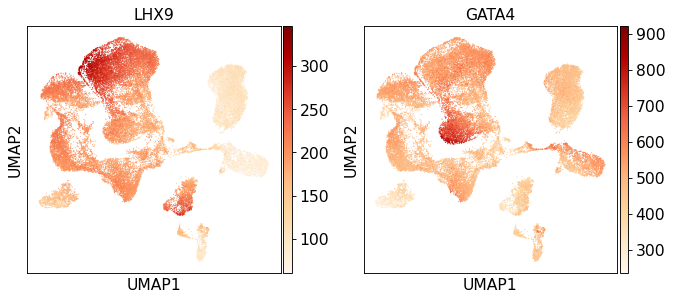

In [68]:
# Gonadal mesenchymal 
sc.pl.umap(gene_adata, color = ['LHX9', 'GATA4'], ncols = 3, color_map = 'OrRd')

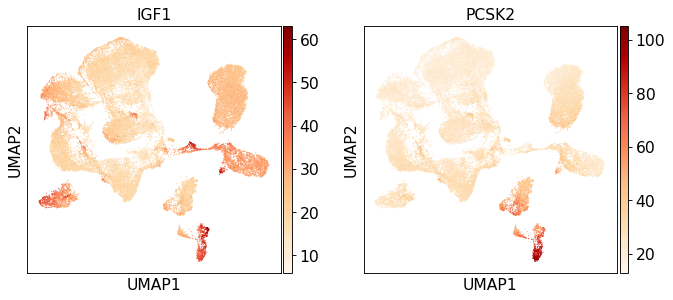

In [69]:
# Testis border mesenchyme
sc.pl.umap(gene_adata, color = ['IGF1', 'PCSK2'], ncols = 3, color_map = 'OrRd')

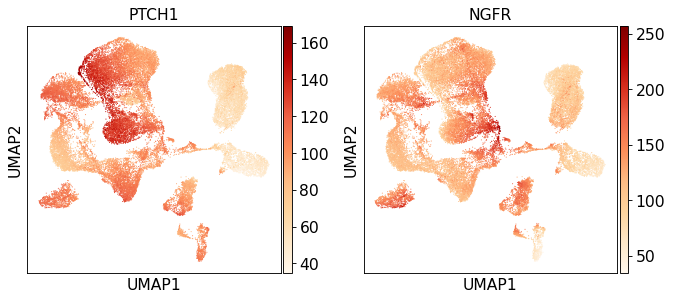

In [70]:
# Testis myoid
sc.pl.umap(gene_adata, color = ['PTCH1', 'NGFR'], ncols = 3, color_map = 'OrRd')

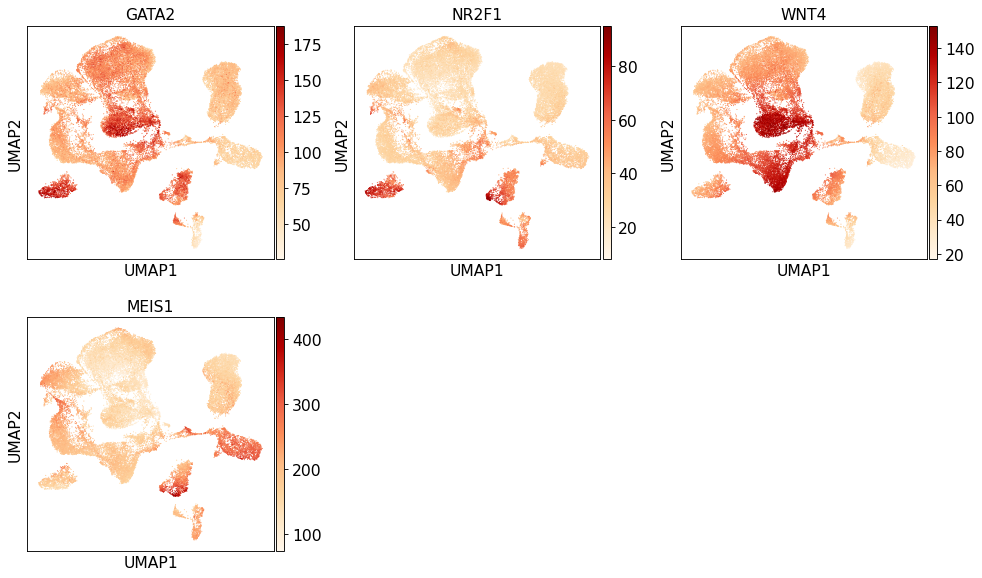

In [71]:
# Extragonal mesenchymal 
sc.pl.umap(gene_adata, color = ['GATA2', 'NR2F1', 'WNT4',  'MEIS1'], ncols = 3, color_map = 'OrRd')

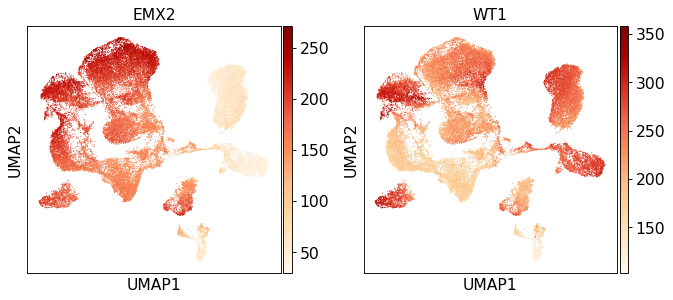

In [72]:
# Gonad dev
sc.pl.umap(gene_adata, color = ['EMX2', 'WT1'], ncols = 3, color_map = 'OrRd')

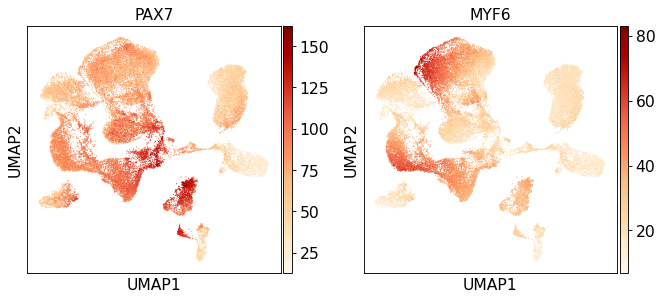

In [73]:
# Muscoskeletal 
sc.pl.umap(gene_adata, color = ['PAX7','MYF6'], ncols = 3, color_map = 'OrRd')

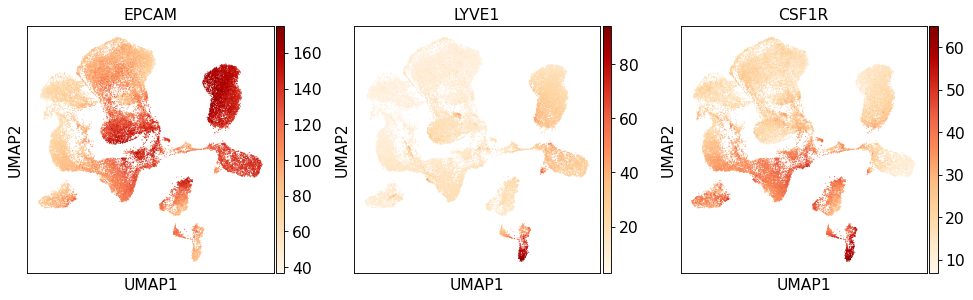

In [74]:
# Epithelial and immune
sc.pl.umap(gene_adata, color = [ 'EPCAM',  'LYVE1', 'CSF1R' 
                                                           ], ncols = 3, color_map = 'OrRd')

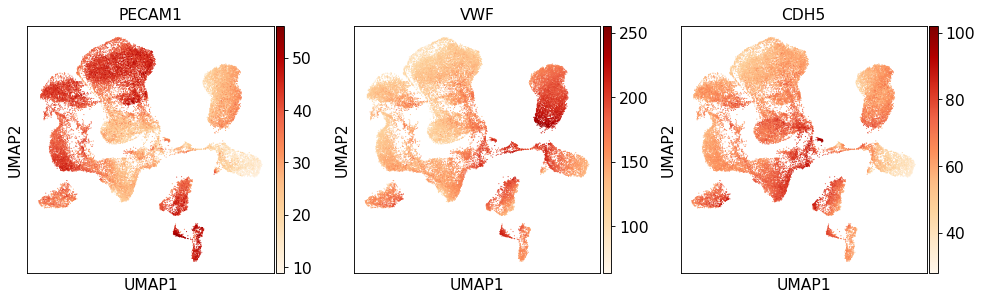

In [75]:
# Endothelial
sc.pl.umap(gene_adata, color = ['PECAM1', 'VWF', 'CDH5'], ncols = 3, color_map = 'OrRd')

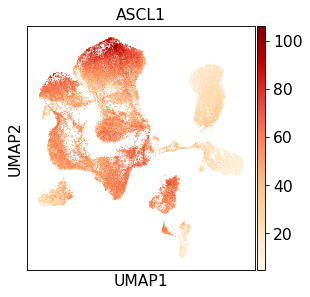

In [76]:
# Neural
sc.pl.umap(gene_adata, color = ['ASCL1'], ncols = 3, color_map = 'OrRd')

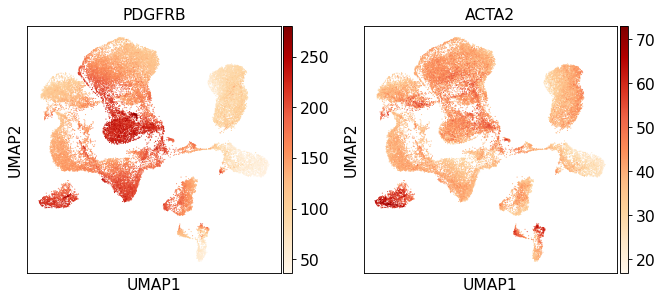

In [77]:
# Perivascular
sc.pl.umap(gene_adata, color = ["PDGFRB", 'ACTA2'], ncols = 3, color_map = 'OrRd')

In [78]:
gene_adata.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

### Compute CCANs enriched in each cell state 

In [42]:
ccans = pd.read_csv(outdir + experiment_prefix + "_ccans_annotated.csv", index_col = 0)
ccans = pd.DataFrame(ccans)
ccans.head()

,Peak,CCAN,peaks_formatted,peak_width,exon,gene_id,gene,gene_name,annotation,promoter,tss_distance,ENCODE_blacklist
1,chr1-100048052-100049110,2,chr1-100048052-100049110,1059,0,ENSG00000156875,1,MFSD14A,intron,0,9560,0
2,chr1-100126934-100127825,2,chr1-100126934-100127825,892,0,ENSG00000156876,1,SASS6,intron,0,5129,0
3,chr1-10012740-10013195,556,chr1-10012740-10013195,456,0,ENSG00000162444,1,RBP7,intron,0,15523,0
4,chr1-1001668-1002133,401,chr1-1001668-1002133,466,0,ENSG00000187608,1,ISG15,promoter,1,522,0
5,chr1-10031483-10031801,556,chr1-10031483-10031801,319,0,ENSG00000130939,0,UBE4B,promoter,1,1030,0


Workflow: 

 * Subset the cells x peaks matrix to keep only the peaks in CCANs
 * Create a new matrix: cell_type x CCANs 
 * Normalize new matrix by CCAN

In [43]:
peaksinCCANs = list(ccans['Peak'])

In [44]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]
cistopic = pd.DataFrame(p_mat_transpose, index=adata.obs_names, columns=adata.var['peaks_formatted'])
cistopic.head()

peaks_formatted,chr1-816745-817421,chr1-825662-826063,chr1-826598-827809,chr1-868837-869161,chr1-869380-870256,chr1-875184-875947,chr1-876172-877361,chr1-901209-901648,chr1-905923-906310,chr1-916391-917443,...,chrY-19043179-19043867,chrY-19066186-19067108,chrY-19075514-19076453,chrY-19076622-19078099,chrY-19566690-19568059,chrY-19572596-19573167,chrY-19578136-19578922,chrY-20559828-20560499,chrY-20574989-20576365,chrY-22727855-22729057
01-AAACGAAAGGCTCCTG-1,1.195574e-06,0.000002,0.000029,6.783465e-07,0.000017,0.000004,0.000006,1.541491e-06,0.000002,0.000020,...,3.236480e-07,4.218387e-07,0.000004,0.000003,0.000006,4.177447e-07,1.106868e-07,1.552034e-07,0.000005,8.315247e-07
01-AAACGAAAGTCCAGAG-1,1.679859e-06,0.000003,0.000027,1.789892e-06,0.000017,0.000004,0.000006,3.219279e-06,0.000002,0.000017,...,6.744857e-07,1.304296e-06,0.000010,0.000007,0.000014,1.590026e-06,5.147049e-07,4.173683e-07,0.000013,2.812159e-06
01-AAACGAACACCCATCT-1,4.224839e-07,0.000003,0.000039,3.035227e-07,0.000024,0.000006,0.000006,3.888931e-07,0.000002,0.000017,...,1.250458e-07,4.359360e-07,0.000001,0.000002,0.000002,9.971916e-07,4.589962e-07,2.523021e-07,0.000002,1.226792e-06
01-AAACGAACAGGTCTGC-1,8.748274e-07,0.000003,0.000034,4.641809e-07,0.000019,0.000005,0.000007,1.025297e-06,0.000002,0.000022,...,2.443473e-07,3.723625e-07,0.000002,0.000002,0.000004,6.292737e-07,2.475397e-07,1.938264e-07,0.000003,9.066134e-07
01-AAACGAAGTAGGGTCA-1,8.815050e-07,0.000003,0.000024,6.392057e-07,0.000017,0.000004,0.000006,1.446079e-06,0.000002,0.000016,...,2.685819e-07,5.774800e-07,0.000003,0.000003,0.000005,9.794606e-07,3.911984e-07,2.465305e-07,0.000004,1.422911e-06


In [45]:
cells_peaksinCCANs = cistopic.loc[:, peaksinCCANs]
cells_peaksinCCANs.shape

(34015, 44220)

**Import cell state annotations and add them**

In [46]:
annots = sc.read(outdir + experiment_prefix + "_harmony_ATAC.wCisTopic.h5ad")
barcodes = list(annots.obs_names)
cells_peaksinCCANs = cells_peaksinCCANs.loc[barcodes, :]

In [47]:
cells_peaksinCCANs.shape

(33909, 44220)

In [48]:
# Mapping of cells to cell types 
annots.obs['barcode'] = annots.obs_names
cells_celltypes = annots.obs[['barcode', 'cell_type']]
cells_celltypes.head()

,barcode,cell_type
01-AAACGAAAGGCTCCTG-1,01-AAACGAAAGGCTCCTG-1,preGC_I_OSR1
01-AAACGAAAGTCCAGAG-1,01-AAACGAAAGTCCAGAG-1,sLGR5
01-AAACGAACACCCATCT-1,01-AAACGAACACCCATCT-1,ovarianSurf
01-AAACGAACAGGTCTGC-1,01-AAACGAACAGGTCTGC-1,preGC_I_OSR1
01-AAACGAAGTAGGGTCA-1,01-AAACGAAGTAGGGTCA-1,preGC_I_OSR1


In [49]:
cells_mapping = cells_celltypes.groupby('cell_type').groups

In [50]:
# Mean by rows 
for key in cells_mapping: 
    print(key)
    cells_peaksinCCANs.loc[key] = cells_peaksinCCANs.loc[cells_mapping[key]].mean(axis = 0)

coelEpi
sKITLG
sLGR5
sPAX8b
sPAX8m
preGC_I_OSR1
ovarianSurf
preGC_II
preGC_II_hypoxia
preGC_III_Notch
Sertoli
FetalLeydig-like


In [51]:
cells_peaksinCCANs.tail()

peaks_formatted,chr1-100048052-100049110,chr1-100126934-100127825,chr1-10012740-10013195,chr1-1001668-1002133,chr1-10031483-10031801,chr1-10043548-10044178,chr1-1004477-1005711,chr1-10045852-10046953,chr1-10057366-10058184,chr1-10066428-10067379,...,chrY-2834065-2835338,chrY-2841211-2842024,chrY-2944351-2944873,chrY-3023178-3023949,chrY-6910347-6911815,chrY-7085436-7086048,chrY-7108784-7109399,chrY-7204239-7205028,chrY-7272513-7273116,chrY-7279357-7279829
preGC_II,0.000002,0.000003,3.864619e-07,0.000026,0.000004,0.000001,0.000026,0.000003,6.753871e-07,0.000007,...,3.429473e-07,0.000001,3.159401e-07,5.623287e-07,9.408689e-07,3.902670e-07,2.728992e-07,6.115999e-07,0.000001,3.758877e-07
preGC_II_hypoxia,0.000003,0.000005,3.645980e-07,0.000022,0.000004,0.000002,0.000030,0.000004,8.001533e-07,0.000009,...,3.598275e-07,0.000001,3.431593e-07,5.942527e-07,8.901487e-07,4.119643e-07,3.022523e-07,6.954681e-07,0.000002,4.489694e-07
preGC_III_Notch,0.000004,0.000007,3.656038e-07,0.000026,0.000002,0.000001,0.000029,0.000004,8.533763e-07,0.000009,...,2.936186e-07,0.000001,2.866129e-07,4.772572e-07,6.766234e-07,3.563429e-07,2.793288e-07,5.990879e-07,0.000001,3.771315e-07
Sertoli,0.000013,0.000023,6.865962e-06,0.000028,0.000014,0.000016,0.000041,0.000004,6.137570e-06,0.000018,...,3.890108e-06,0.000018,3.587406e-06,6.667382e-06,9.995137e-06,5.434500e-06,4.885290e-06,9.160480e-06,0.000022,5.504333e-06
FetalLeydig-like,0.000003,0.000005,7.964599e-07,0.000022,0.000004,0.000004,0.000030,0.000009,3.650310e-06,0.000020,...,2.428285e-06,0.000011,8.037476e-07,4.957700e-06,5.726732e-06,6.398325e-06,8.670816e-07,7.017326e-06,0.000009,1.517086e-06


In [52]:
cells_peaksinCCANs.shape

(33921, 44220)

In [53]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
cells_peaksinCCANs = cells_peaksinCCANs.loc[rows_celltypes, ]

['FetalLeydig-like', 'Sertoli', 'coelEpi', 'ovarianSurf', 'preGC_II', 'preGC_III_Notch', 'preGC_II_hypoxia', 'preGC_I_OSR1', 'sKITLG', 'sLGR5', 'sPAX8b', 'sPAX8m']


In [54]:
cells_peaksinCCANs

peaks_formatted,chr1-100048052-100049110,chr1-100126934-100127825,chr1-10012740-10013195,chr1-1001668-1002133,chr1-10031483-10031801,chr1-10043548-10044178,chr1-1004477-1005711,chr1-10045852-10046953,chr1-10057366-10058184,chr1-10066428-10067379,...,chrY-2834065-2835338,chrY-2841211-2842024,chrY-2944351-2944873,chrY-3023178-3023949,chrY-6910347-6911815,chrY-7085436-7086048,chrY-7108784-7109399,chrY-7204239-7205028,chrY-7272513-7273116,chrY-7279357-7279829
FetalLeydig-like,0.000003,0.000005,7.964599e-07,0.000022,0.000004,0.000004,0.000030,0.000009,3.650310e-06,0.000020,...,2.428285e-06,0.000011,8.037476e-07,4.957700e-06,5.726732e-06,6.398325e-06,8.670816e-07,7.017326e-06,0.000009,1.517086e-06
Sertoli,0.000013,0.000023,6.865962e-06,0.000028,0.000014,0.000016,0.000041,0.000004,6.137570e-06,0.000018,...,3.890108e-06,0.000018,3.587406e-06,6.667382e-06,9.995137e-06,5.434500e-06,4.885290e-06,9.160480e-06,0.000022,5.504333e-06
coelEpi,0.000002,0.000003,5.724203e-07,0.000029,0.000017,0.000001,0.000014,0.000011,6.840193e-07,0.000006,...,3.864745e-07,0.000001,3.391890e-07,6.394635e-07,1.433752e-06,5.716545e-07,3.033069e-07,6.020586e-07,0.000001,3.196199e-07
ovarianSurf,0.000002,0.000002,4.939618e-07,0.000028,0.000010,0.000001,0.000016,0.000003,5.489461e-07,0.000005,...,3.820773e-07,0.000001,3.219498e-07,5.709171e-07,1.045324e-06,4.032900e-07,2.689639e-07,5.706061e-07,0.000001,3.226580e-07
preGC_II,0.000002,0.000003,3.864619e-07,0.000026,0.000004,0.000001,0.000026,0.000003,6.753871e-07,0.000007,...,3.429473e-07,0.000001,3.159401e-07,5.623287e-07,9.408689e-07,3.902670e-07,2.728992e-07,6.115999e-07,0.000001,3.758877e-07
preGC_III_Notch,0.000004,0.000007,3.656038e-07,0.000026,0.000002,0.000001,0.000029,0.000004,8.533763e-07,0.000009,...,2.936186e-07,0.000001,2.866129e-07,4.772572e-07,6.766234e-07,3.563429e-07,2.793288e-07,5.990879e-07,0.000001,3.771315e-07
preGC_II_hypoxia,0.000003,0.000005,3.645980e-07,0.000022,0.000004,0.000002,0.000030,0.000004,8.001533e-07,0.000009,...,3.598275e-07,0.000001,3.431593e-07,5.942527e-07,8.901487e-07,4.119643e-07,3.022523e-07,6.954681e-07,0.000002,4.489694e-07
preGC_I_OSR1,0.000005,0.000012,4.253877e-07,0.000036,0.000006,0.000002,0.000031,0.000003,9.619332e-07,0.000008,...,3.502332e-07,0.000002,3.335580e-07,6.065817e-07,9.344045e-07,4.558780e-07,3.408751e-07,7.540347e-07,0.000002,4.780864e-07
sKITLG,0.000003,0.000004,7.857644e-07,0.000028,0.000009,0.000002,0.000024,0.000003,1.199673e-06,0.000006,...,7.734700e-07,0.000003,5.855352e-07,1.947693e-06,6.465553e-06,1.290973e-06,5.015288e-07,1.159290e-06,0.000003,6.478771e-07
sLGR5,0.000005,0.000015,5.833293e-07,0.000026,0.000008,0.000004,0.000035,0.000003,1.436241e-06,0.000008,...,6.645682e-07,0.000004,6.359105e-07,1.344587e-06,2.204341e-06,9.548795e-07,6.950659e-07,1.657297e-06,0.000005,1.141758e-06


In [55]:
# Mapping of peaks to CCANs 
ccans = ccans.set_index('peaks_formatted')
peaks_ccans = ccans[['Peak', 'CCAN']]
peaks_mapping = peaks_ccans.groupby('CCAN').groups

In [56]:
# Mean by columns 
for key in peaks_mapping: 
    #print(key)
    cells_peaksinCCANs[key] = cells_peaksinCCANs[peaks_mapping[key]].mean(axis = 1)

In [57]:
cells_peaksinCCANs.shape

(12, 47772)

In [58]:
cols_ccans = list(np.unique(peaks_ccans['CCAN']))
# Select only aggregated rows and columns 
celltype_CCANs = cells_peaksinCCANs.loc[:, cols_ccans]

In [59]:
celltype_CCANs

peaks_formatted,2,6,9,10,12,13,16,17,20,21,...,6762,6763,6764,6766,6767,6769,6770,6771,6773,6774
FetalLeydig-like,0.000003,0.000005,1.368324e-06,0.000004,2.059490e-06,0.000006,0.000003,0.000004,0.000008,0.000009,...,0.000005,1.871851e-06,0.000002,0.000008,4.547186e-06,5.555633e-06,0.000008,0.000010,4.541692e-06,5.017518e-06
Sertoli,0.000015,0.000004,7.311294e-07,0.000003,8.960967e-07,0.000014,0.000013,0.000002,0.000004,0.000006,...,0.000013,8.848138e-06,0.000001,0.000006,9.817243e-06,8.714034e-06,0.000017,0.000025,7.691864e-06,9.565156e-06
coelEpi,0.000002,0.000006,8.493143e-06,0.000004,6.966907e-06,0.000002,0.000004,0.000005,0.000007,0.000014,...,0.000003,7.029356e-07,0.000003,0.000009,7.202512e-07,7.417043e-07,0.000001,0.000003,5.717829e-07,7.490078e-07
ovarianSurf,0.000001,0.000007,1.508102e-05,0.000011,1.658579e-05,0.000002,0.000002,0.000012,0.000008,0.000011,...,0.000002,7.130544e-07,0.000013,0.000009,6.353581e-07,6.028937e-07,0.000001,0.000002,5.414623e-07,6.420805e-07
preGC_II,0.000002,0.000008,6.502582e-06,0.000017,1.037314e-05,0.000002,0.000002,0.000015,0.000010,0.000013,...,0.000002,7.984330e-07,0.000011,0.000010,6.805588e-07,6.243376e-07,0.000001,0.000002,5.714298e-07,6.750363e-07
preGC_III_Notch,0.000004,0.000021,4.906221e-06,0.000006,9.538796e-06,0.000002,0.000002,0.000015,0.000018,0.000011,...,0.000003,8.094842e-07,0.000009,0.000018,6.510311e-07,5.881403e-07,0.000001,0.000002,5.348270e-07,6.257018e-07
preGC_II_hypoxia,0.000003,0.000010,5.243650e-06,0.000014,8.667083e-06,0.000002,0.000002,0.000016,0.000012,0.000013,...,0.000003,1.014818e-06,0.000012,0.000011,7.714643e-07,6.951787e-07,0.000001,0.000002,6.407402e-07,7.467639e-07
preGC_I_OSR1,0.000006,0.000010,1.889416e-06,0.000005,2.673605e-06,0.000002,0.000002,0.000003,0.000020,0.000017,...,0.000003,1.239770e-06,0.000003,0.000014,8.278723e-07,7.403428e-07,0.000001,0.000002,6.726793e-07,8.103021e-07
sKITLG,0.000003,0.000006,3.722101e-06,0.000010,8.622726e-06,0.000004,0.000006,0.000005,0.000006,0.000015,...,0.000003,1.245272e-06,0.000003,0.000008,1.649166e-06,1.489105e-06,0.000003,0.000004,1.331065e-06,2.242511e-06
sLGR5,0.000007,0.000008,2.060974e-06,0.000007,3.971194e-06,0.000003,0.000003,0.000004,0.000013,0.000017,...,0.000005,2.266433e-06,0.000004,0.000010,1.883492e-06,1.633869e-06,0.000003,0.000005,1.498014e-06,1.881327e-06


In [60]:
celltype_CCANs = celltype_CCANs.loc[(celltype_CCANs.sum(axis=1) != 0), (celltype_CCANs.sum(axis=0) != 0)]

In [61]:
celltype_CCANs.shape

(12, 3552)

In [62]:
# Normalize by column (CCAN)
from scipy.stats import zscore
celltype_CCANs_zscore = celltype_CCANs.apply(zscore)

In [63]:
celltype_CCANs_zscore

peaks_formatted,2,6,9,10,12,13,16,17,20,21,...,6762,6763,6764,6766,6767,6769,6770,6771,6773,6774
FetalLeydig-like,-0.282371,-0.670562,-0.798324,-0.767710,-0.898715,0.801429,-0.393931,-0.683581,-0.645872,-1.255459,...,0.286591,0.009418,-0.784363,-0.796013,0.931888,1.460838,0.870018,0.702823,1.324807,1.107414
Sertoli,2.954510,-0.985900,-0.961385,-0.982714,-1.153459,3.036978,3.027668,-0.955837,-1.327667,-2.174437,...,3.115435,3.232283,-0.939312,-1.246272,2.987592,2.766362,2.987591,3.046596,2.831121,2.899718
coelEpi,-0.776564,-0.566725,1.024950,-0.812584,0.175848,-0.628977,0.017240,-0.533063,-0.803519,0.329343,...,-0.583842,-0.530591,-0.475958,-0.306795,-0.560893,-0.528998,-0.560868,-0.441870,-0.573480,-0.574882
ovarianSurf,-0.815548,-0.312232,2.710819,0.885930,2.282068,-0.502859,-0.478757,0.973698,-0.647532,-0.516525,...,-0.748315,-0.525916,1.775871,-0.236774,-0.594008,-0.586375,-0.616410,-0.610636,-0.587978,-0.617024
preGC_II,-0.663993,0.011145,0.515557,2.210671,0.921702,-0.483360,-0.601482,1.496000,-0.144071,-0.131734,...,-0.694078,-0.486474,1.372789,0.106064,-0.576376,-0.577511,-0.597653,-0.600087,-0.573648,-0.604035
preGC_III_Notch,-0.130214,3.017108,0.107040,-0.198184,0.739007,-0.627416,-0.700469,1.483729,1.617653,-0.579699,...,-0.433675,-0.481368,0.890079,2.592425,-0.587894,-0.592473,-0.611669,-0.609362,-0.591151,-0.623479
preGC_II_hypoxia,-0.402916,0.502362,0.193390,1.436954,0.548131,-0.460292,-0.497009,1.600312,0.393200,0.005846,...,-0.507572,-0.386510,1.449923,0.420299,-0.540916,-0.548229,-0.561927,-0.563401,-0.540506,-0.575766
preGC_I_OSR1,0.404049,0.406073,-0.664974,-0.449318,-0.764243,-0.575201,-0.706651,-0.758584,2.118079,1.270163,...,-0.275892,-0.282588,-0.671178,1.261010,-0.518913,-0.529561,-0.536845,-0.536087,-0.525234,-0.550725
sKITLG,-0.480423,-0.445477,-0.195981,0.530149,0.538418,-0.042381,0.634419,-0.443193,-0.986658,0.506831,...,-0.366826,-0.280046,-0.477824,-0.678112,-0.198549,-0.220060,-0.092658,-0.164429,-0.210414,0.013734
sLGR5,0.835608,-0.057991,-0.621071,-0.114513,-0.480114,-0.134999,-0.133913,-0.643466,0.616352,1.085364,...,0.302918,0.191704,-0.410338,-0.067970,-0.107145,-0.160222,-0.092854,-0.098650,-0.130585,-0.128615


In [64]:
celltype_CCANs_zscore = celltype_CCANs_zscore.reindex(['coelEpi', 'sKITLG', 'sLGR5', 'sPAX8b', 'sPAX8m',
                                                        'preGC_I_OSR1','ovarianSurf', 'preGC_II','preGC_II_hypoxia',  'preGC_III_Notch', 
                                                      'Sertoli', 'FetalLeydig-like', ])


In [65]:
celltype_CCANs_zscore.to_csv(outdir + experiment_prefix + "zscore_ccans.csv")

In [12]:
celltype_CCANs_zscore = pd.read_csv(outdir + experiment_prefix + "zscore_ccans.csv", index_col = 0)

In [10]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

<ipython-input-14-0e9b15eee14e>:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())


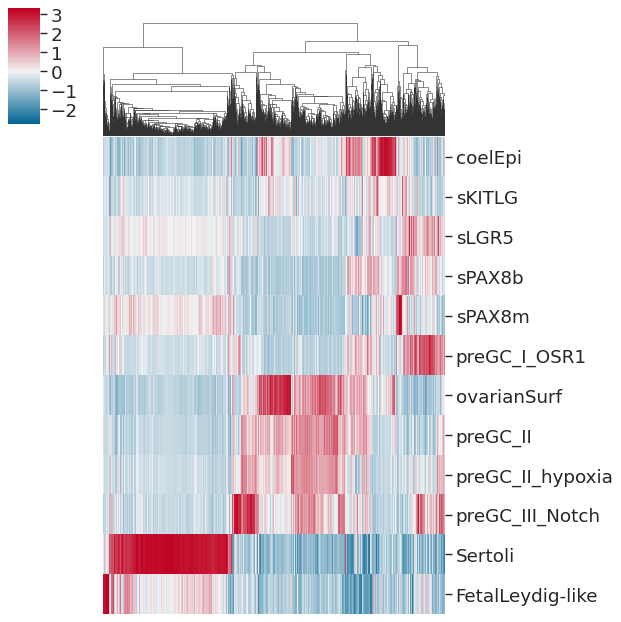

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
my_cmap = sns.diverging_palette(240, 10, n=10, s = 100, l = 40, as_cmap=True)
sns.set(font_scale=1.5)
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=celltype_CCANs_zscore.values.min(), vcenter=0, vmax=celltype_CCANs_zscore.values.max())

heatmap = sns.clustermap(celltype_CCANs_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = my_cmap, norm = divnorm)
heatmap.savefig("/home/jovyan/MULTIOME_april2021/figures_supporting/heatmap_supporting_cicero.pdf", transparent=True)

### UMAP embedding of CCANs

In [67]:
# Create anndata 
celltype_CCANs_zscore_transposed = celltype_CCANs_zscore.transpose()
ccans_adata = anndata.AnnData(X = celltype_CCANs_zscore_transposed)
ccans_adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 3552 × 12

In [68]:
sc.pp.neighbors(ccans_adata, random_state= 123)
sc.tl.umap(ccans_adata)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


In [69]:
ccans_adata.obs['supporting_value'] = ccans_adata.X.argmax(axis=1)

In [70]:
ccans_adata.obs['supporting_value'].value_counts(dropna = False)

10    1260
6      598
9      418
0      392
5      248
7      226
11      97
3       80
8       75
4       65
2       63
1       30
Name: supporting_value, dtype: int64

In [71]:
supporting_cluster = {0 : 'coelEpi', 1 : 'sKITLG', 2 : 'sLGR5', 3 :'sPAX8b', 4 : 'sPAX8m',
                    5 : 'preGC_I_OSR1', 6 : 'ovarianSurf', 7 : 'preGC_II', 8 : 'preGC_II_hypoxia', 9: 'preGC_III_Notch', 
                    10 : 'Sertoli', 11 : 'FetalLeydig-like', }
ccans_adata.obs['clusters'] = ccans_adata.obs['supporting_value'].map(supporting_cluster)
ccans_adata.obs['clusters'].value_counts(dropna = False)

Sertoli             1260
ovarianSurf          598
preGC_III_Notch      418
coelEpi              392
preGC_I_OSR1         248
preGC_II             226
FetalLeydig-like      97
sPAX8b                80
preGC_II_hypoxia      75
sPAX8m                65
sLGR5                 63
sKITLG                30
Name: clusters, dtype: int64

In [74]:
new_palette = ['#7b9e99','#91bd80','#bdb380','#d4db81','#70ccbe','#cc8fdb','#edb7b7','#d9abb7','#e08b8b', 
                '#e64e74', '#aad3f2', '#60bddb']

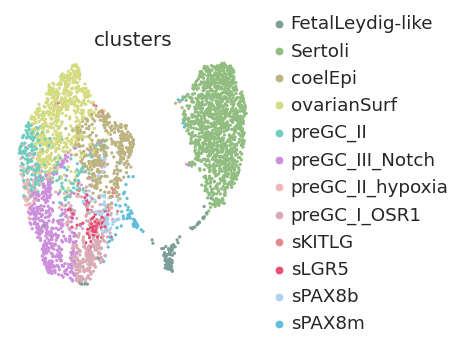

In [75]:
sc.pl.umap(ccans_adata, color = 'clusters', frameon = False,  outline_color = ('black', 'white'),
           palette = new_palette, save = "_supporting_ccans_umap.pdf")

In [76]:
ccans_adata.obs['clusters'] = ccans_adata.obs['clusters'].cat.reorder_categories([
    'coelEpi', 'sKITLG', 'sLGR5', 'sPAX8b', 'sPAX8m',
                                                        'preGC_I_OSR1','ovarianSurf', 'preGC_II','preGC_II_hypoxia',  'preGC_III_Notch', 
                                                      'Sertoli', 'FetalLeydig-like'
])

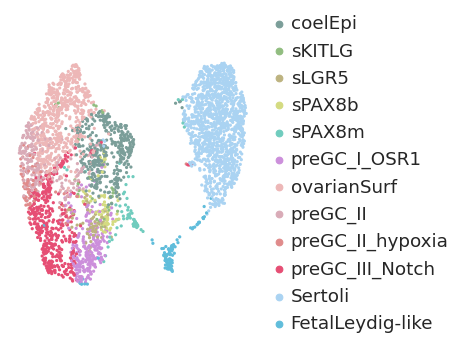

In [77]:


sc.pl.umap(ccans_adata, color = 'clusters', title = "", frameon = False,  outline_color = ('black', 'white'),
           palette = new_palette, save = "_supporting_ccans_umap_gonadscolors.pdf")

#### End of notebook